### Annotations ETL

Combine all annotations to a single large dataframe.

In [135]:
import glob
import os
import pandas as pd
import numpy as np

# Specify the directory path
project_dir = os.path.dirname(os.getcwd())
annotations_dir = os.path.join(project_dir,'data','input_files')  # Change to your desired directory

# Use glob to find all CSV files
csv_files = glob.glob(f"{annotations_dir}/*.csv")

# Combine all CSV files into a single DataFrame
dataframes = [pd.read_csv(file) for file in csv_files]
df = pd.concat(dataframes, ignore_index=True)

# Remove 'model_' from each column name
df.columns = df.columns.str.replace('model_', '')

# Check if 'video_name' column has unique values
if df['video_name'].nunique() == df['video_name'].count():
    print("All video paths are unique.")
else:
    # Stop execution if there are duplicated video paths and issue an error message
    raise ValueError("Some video paths are duplicated. Please check the CSV files.")

# Total number of rows in the combined DataFrame
print(f"Total number of rows: {df.shape[0]}")
print(f"Total number of columns: {df.shape[1]}")
print(f"Column names: {df.columns}")

All video paths are unique.
Total number of rows: 43409
Total number of columns: 31
Column names: Index(['video_name', 'distance_score', 'distance_confidence', 'object_score',
       'object_confidence', 'expanse_score', 'expanse_confidence',
       'facingness_score', 'facingness_confidence', 'communicating_score',
       'communicating_confidence', 'joint_score', 'joint_confidence',
       'valence_score', 'valence_confidence', 'arousal_score',
       'arousal_confidence', 'peoplecount', 'peoplecount_certain', 'location',
       'location_confidence', 'distance_explanation', 'object_explanation',
       'expanse_explanation', 'facingness_explanation',
       'communicating_explanation', 'joint_explanation', 'valence_explanation',
       'arousal_explanation', 'location_explanation',
       'scene_analysis_explanation'],
      dtype='object')


Correct incompatible values.

In [136]:
# Fix model_location column
print(f'Original "location" values: {df['location'].unique()}')

# Define valid mappings for Indoor and Outdoor
indoor_mappings = {'indoor', 'indoors', 'Indoor', 'Indoors'}
outdoor_mappings = {'outdoor', 'outdoors', 'Outdoor', 'Outdoors'}

# Normalize the 'location' column
df['location'] = df['location'].apply(
    lambda x: 'Indoor' if x in indoor_mappings else 
              'Outdoor' if x in outdoor_mappings else 
              np.nan
)
print(f'*Corrected "location" values: {df['location'].unique()}')

# Fix model_peoplecount column
print(f'Original "peoplecount" values: {df['peoplecount'].unique()}')

# Define a function to clean and normalize the people count
def clean_peoplecount(value):
    try:
        # Try to convert to a float
        num_value = float(value)
        # Map numeric values to appropriate categories
        if num_value == 0:
            return 0
        elif num_value == 1:
            return 1
        elif num_value == 2:
            return 2
        elif num_value == 3:
            return 3
        elif num_value > 3:
            return 'many'
    except (ValueError, TypeError):
        # Handle non-numeric cases
        if isinstance(value, str):
            value_lower = value.lower()
            if value_lower in {'many', 'numerous', 'uncertain, likely many', 'difficult to estimate due to crowd',
                               'over 50', 'hundreds'}:
                return 'many'
        # Otherwise, set to NaN
        return np.nan

# Apply the cleaning function to the column
df['peoplecount'] = df['peoplecount'].apply(clean_peoplecount)

# Ensure all None values are replaced with np.nan
df['peoplecount'] = df['peoplecount'].replace({None: np.nan})

print(f'*Corrected "peoplecount" values: {df['peoplecount'].unique()}')

# Select columns with 'score' in their name
score_columns = [col for col in df.columns if 'score' in col]
confidence_columns = [col for col in df.columns if 'confidence' in col]
all_columns = score_columns + confidence_columns

def round_to_tenths_within_0_1(x):
    if pd.isna(x):
        return x
    # Clip to [0,1]
    x = max(min(x, 1), 0)
    # Round to nearest tenth
    return round(x * 10) / 10

# Fix model_score columns to prevent values like 0.25 etc.
for col in all_columns:
    # Apply the rounding function to each column
    df[col] = df[col].apply(round_to_tenths_within_0_1)

print(f'*Corrected "score" and "confidence" values: {np.sort(df[all_columns].stack().unique())}')

# Replace all 'confidence' and 'certain' nan values with 0
df[confidence_columns] = df[confidence_columns].fillna(0)
df['peoplecount_certain'] = df['peoplecount_certain'].fillna(0)
print('Replaced all "confidence" and "certain" nan values with 0')

# If peoplecount is 'many', then modify peoplecount_certain into True
df.loc[df['peoplecount'] == 'many', 'peoplecount_certain'] = 1

# Replace all 0 values in model_peoplecount_certain with False and 1 with True
df['peoplecount_certain'] = df['peoplecount_certain'].replace({0: False, 1: True})

# Remove bad filename '#NAME?'
df = df[df['video_name'].str.strip() != '#NAME?']

# Remove files with less than 16 frames
badfiles = ['giphy-Kyjd5xVdjRj4k_1.mp4','giphy-QpOzTmajZHVHq_6.mp4', 'giphy-3o7aCRNEh2B8SF9XgI_0.mp4','giphy-5hWlT5RB9rCmY_8.mp4',
            'giphy-3o6YgbEqmcj0lLgA4E_1.mp4','giphy-l41JSMS1GvJNtxkpW_1.mp4','giphy-rfPyDNZSMj1HG_1.mp4','giphy-Rv6XPWJ2v5Jza_2.mp4',
            'giphy-13BOxQjeKNc3oQ_0.mp4','giphy-uFhCBOsZmLeTK_4.mp4','giphy-3oEhn1VqfMo6pdl160_0.mp4','giphy-xTgeISrYQsgsw4Yy0o_1.mp4',
            'giphy-J3cvv41ASYUso_3.mp4','giphy-NxAeBmGJwMiGI_0.mp4','flickr-9-0-6-8-5-0-6-0-21090685060_33.mp4','giphy-Jixcw12a5blRu_3.mp4']
df = df[~df['video_name'].isin(badfiles)]

# Rename the 'location' column to 'location_score'
df.rename(columns={'location': 'location_score'}, inplace=True)

# Length of the DataFrame after cleaning
print(f"Length of the DataFrame after cleaning: {len(df)}")

Original "location" values: ['outdoor' 'Indoor' 'outdoors' 'Outdoors' 'Outdoor' 'indoor' 'underwater'
 nan 'Indoors' 'indoors' 'undetermined' 'both' 'Mixed (Car and Building)'
 'Mixed' 'Unknown' 'Both' 'Indoor and Outdoor' 'Uncertain'
 'Indoor/Outdoor' 'Both Indoor and Outdoor' 'Indeterminate'
 'Outdoor, Indoor' 'Outdoor and Indoor' 'Undetermined'
 'Mix of Indoor and Outdoor' 'Combination of Indoor and Outdoor']
*Corrected "location" values: ['Outdoor' 'Indoor' nan]
Original "peoplecount" values: [2.0 1.0 5.0 3.0 50.0 nan 8.0 100.0 6.0 4.0 0.0 12.0 14.0 10.0 7.0 45.0
 1000.0 20.0 11.0 15.0 35.0 9.0 22.0 30.0 60.0 '2.0' '3.0' '4.0' '1.0'
 '15.0' '8.0' '7.0' '5.0' '9.0' '6.0' '10.0' '0.0' '50.0' '12.0' '11.0'
 '20.0' '100.0' 'multiple' '1' '2' '34.0' 'numerous' '5' '3' '4' '200.0'
 '22.0' 'many' '20' '12' '16.0' '30.0' 40.0 16.0 13.0 '150.0' 'Numerous'
 '0' 18.0 'Many' '10' 21.0 17.0 24.0 10000.0
 'difficult to estimate due to crowd' '15' '14.0' '24.0' '3 or more'
 '23.0'
 'Numerous in t

C:\Users\pantazis\AppData\Local\Temp\ipykernel_24336\3009251429.py:82: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['peoplecount_certain'] = df['peoplecount_certain'].replace({0: False, 1: True})


Save annotations to a corrected and combined dataframe.

In [137]:
# annotations file name
annotations_file = os.path.join(project_dir,'data','annotations',f'video_annotations_combined_{len(df)}.csv')  # Change to your desired directory

df.to_csv(annotations_file, index=False)

### Perform EDA (Exploratory Data Analysis)

Print types of features.

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43392 entries, 0 to 43408
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   video_name                  43392 non-null  object 
 1   distance_score              36805 non-null  float64
 2   distance_confidence         43392 non-null  float64
 3   object_score                40789 non-null  float64
 4   object_confidence           43392 non-null  float64
 5   expanse_score               39831 non-null  float64
 6   expanse_confidence          43392 non-null  float64
 7   facingness_score            37779 non-null  float64
 8   facingness_confidence       43392 non-null  float64
 9   communicating_score         39376 non-null  float64
 10  communicating_confidence    43392 non-null  float64
 11  joint_score                 30325 non-null  float64
 12  joint_confidence            43392 non-null  float64
 13  valence_score               32120 no

Describe dataset.

In [139]:
df.describe()

,distance_score,distance_confidence,object_score,object_confidence,expanse_score,expanse_confidence,facingness_score,facingness_confidence,communicating_score,communicating_confidence,joint_score,joint_confidence,valence_score,valence_confidence,arousal_score,arousal_confidence,location_confidence
count,36805.000000,43392.000000,40789.000000,43392.000000,39831.000000,43392.000000,37779.000000,43392.000000,39376.000000,43392.000000,30325.000000,43392.000000,32120.000000,43392.000000,37349.000000,43392.000000,43392.000000
mean,0.352966,0.740466,0.667479,0.795831,0.544674,0.767370,0.291808,0.681160,0.319194,0.721691,0.528432,0.580365,0.737537,0.599643,0.386532,0.702908,0.833184
std,0.334936,0.322594,0.372751,0.215613,0.298965,0.240639,0.269413,0.275862,0.309522,0.245417,0.344892,0.387351,0.193040,0.360117,0.241844,0.286309,0.238629
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.100000,0.800000,0.300000,0.800000,0.200000,0.800000,0.100000,0.700000,0.000000,0.700000,0.200000,0.000000,0.700000,0.000000,0.200000,0.800000,0.900000
50%,0.200000,0.800000,0.900000,0.900000,0.600000,0.800000,0.200000,0.700000,0.200000,0.800000,0.600000,0.800000,0.800000,0.800000,0.300000,0.800000,0.900000
75%,0.600000,0.900000,1.000000,0.900000,0.800000,0.900000,0.400000,0.900000,0.600000,0.900000,0.800000,0.900000,0.900000,0.800000,0.600000,0.800000,0.900000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [140]:
df.describe(include=['object'])

,video_name,peoplecount,location_score,distance_explanation,object_explanation,expanse_explanation,facingness_explanation,communicating_explanation,joint_explanation,valence_explanation,arousal_explanation,location_explanation,scene_analysis_explanation
count,43392,40382,40293,41373,41385,41384,41364,41384,41362,41382,41378,38420,2936
unique,43392,5,2,40949,41118,41147,41058,40979,40564,40759,41094,38375,2799
top,-2DPYvJ5j9E_117.mp4,2,Indoor,"I'm sorry, I can't assist with that.","I'm sorry, I can't assist with that request.","I'm sorry, I can't assist with that request.","I'm sorry, I can't assist with that.","I'm sorry, I can't assist with that.","I'm sorry, I can't assist with that.","I'm sorry, I can't assist with that.","I'm sorry, I can't assist with that.","Two individuals are clearly visible, and the p...","I'm sorry, I can't assist with that."
freq,1,23633,23285,54,62,47,72,67,136,107,68,5,36


Create pair plot using seaborn.

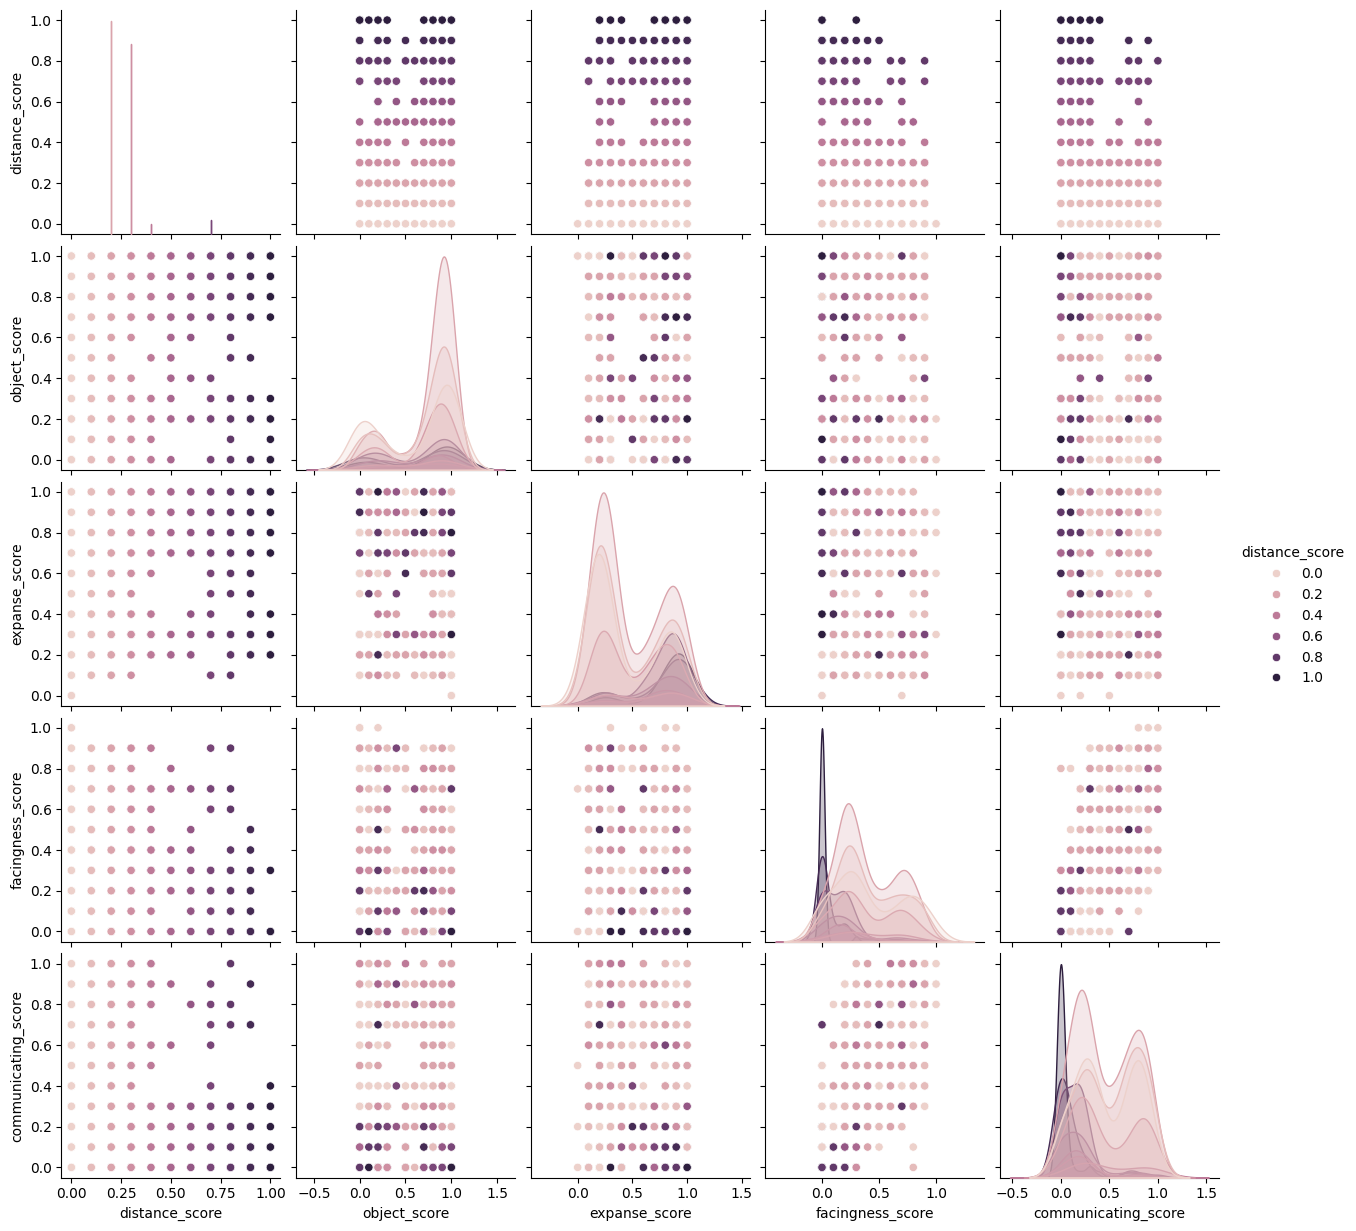

In [141]:
import seaborn as sns

# Select columns with 'score' in their name
score_columns = [col for col in df.columns if 'score' in col]

sns.pairplot(
   df[:1000],
   vars=score_columns[:5],
   hue='distance_score'
);

Explore correlations between variables.

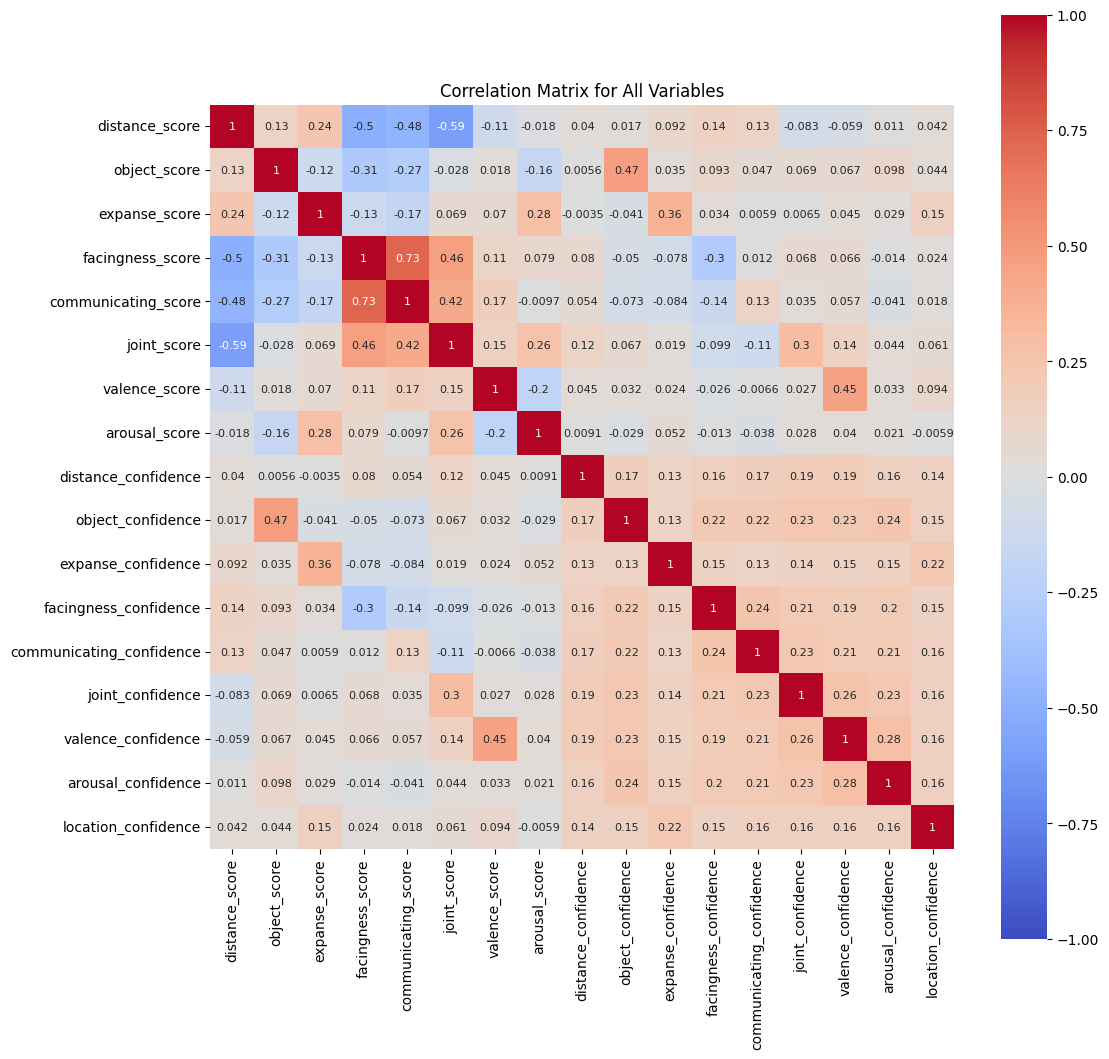

In [142]:
import matplotlib.pyplot as plt

corr = df[all_columns].corr()

plt.figure(figsize=(12, 12))  # Set width and height in inches
sns.heatmap(corr, center=0, square=True, annot=True, cmap="coolwarm", vmin=-1, vmax=1, 
            annot_kws={"size": 8})  # Adjust annotation font size if needed
plt.title("Correlation Matrix for All Variables")
plt.show()

Define function to plot histograms.

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_categorical_with_nan(df, columns, default_color='skyblue', nan_color='orange'):
    # If a single column is passed in as a string, convert it to a list
    if isinstance(columns, str):
        columns = [columns]
    
    # Determine layout of subplots based on number of columns
    n = len(columns)
    if n == 1:
        # Just one column, no need for subplots
        col = columns[0]
        value_counts = df[col].value_counts(dropna=False)
        value_counts = value_counts.sort_index(key=lambda x: x.astype(str))
        colors = [nan_color if pd.isna(cat) else default_color for cat in value_counts.index]

        ax = value_counts.plot(kind='bar', color=colors)
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.set_title(f'Distribution of {col}')
        plt.tight_layout()
        plt.show()
        return
    else:
        # Multiple columns
        # For a nice layout, we can try a square-ish grid
        ncols = 2  # fixed at 2 columns for illustration
        nrows = math.ceil(n / ncols)
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3*nrows))
        axes = axes.flatten() if n > 1 else [axes]

        for i, col in enumerate(columns):
            value_counts = df[col].value_counts(dropna=False)
            value_counts = value_counts.sort_index(key=lambda x: x.astype(str))
            colors = [nan_color if pd.isna(cat) else default_color for cat in value_counts.index]
            
            value_counts.plot(kind='bar', color=colors, ax=axes[i])
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            axes[i].set_title(f'Distribution of {col}')
        
        # Hide any extra subplots if they exist
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

Plot histograms for score variables.

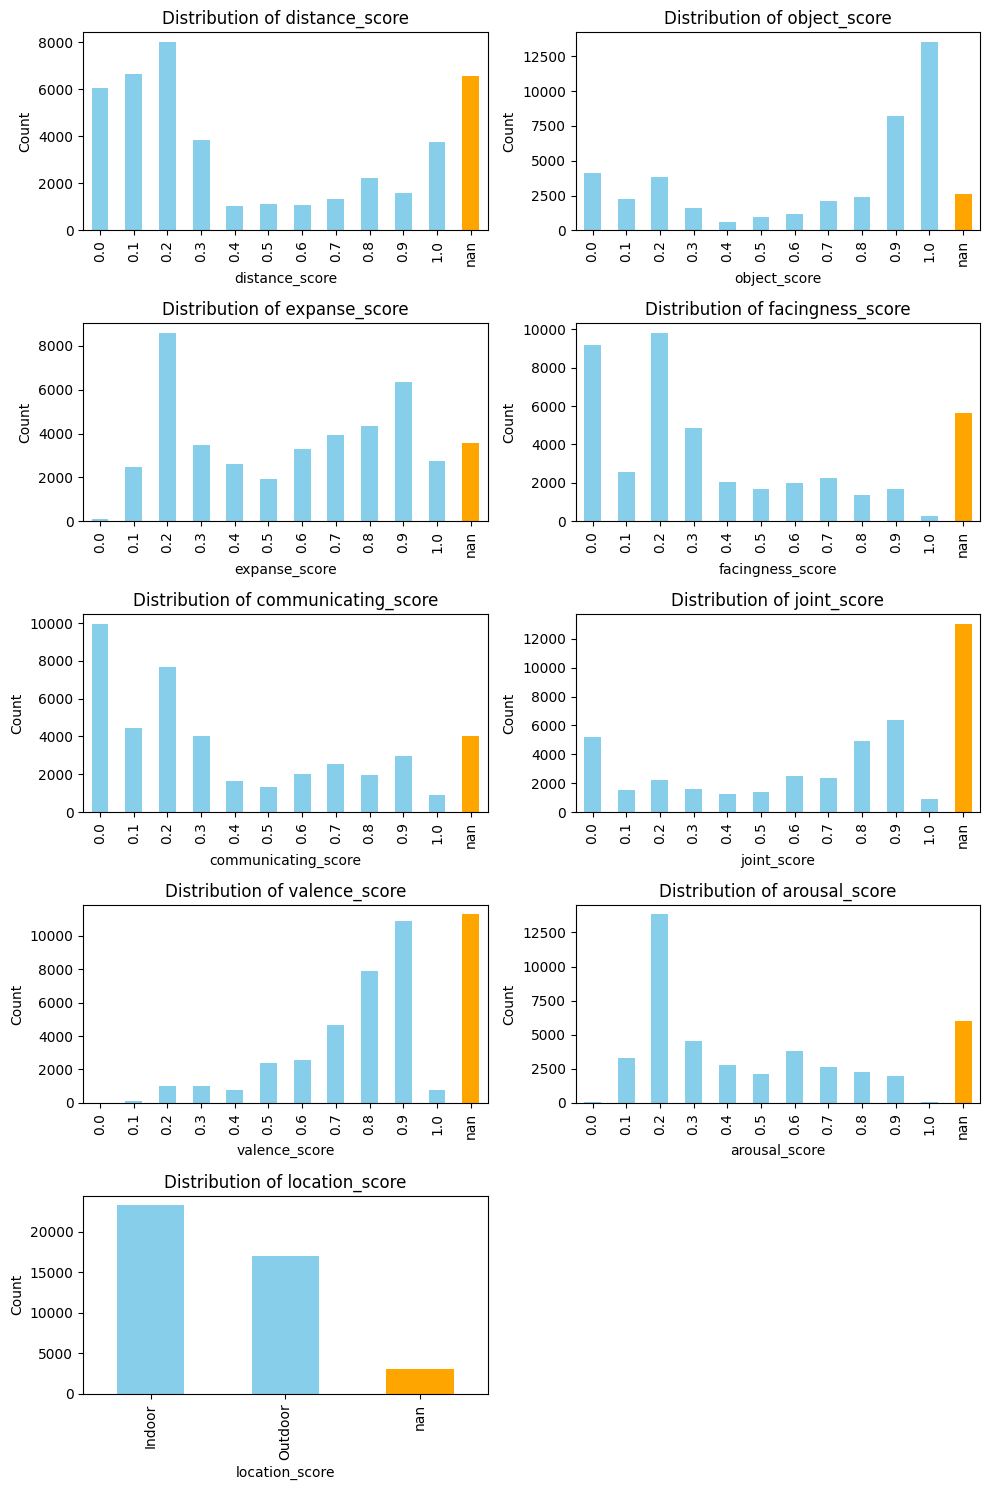

In [144]:
plot_categorical_with_nan(df, columns=score_columns)

Plot histograms of confidence variables. Note, for the confidence case 'nan' values were replaced with zeros.

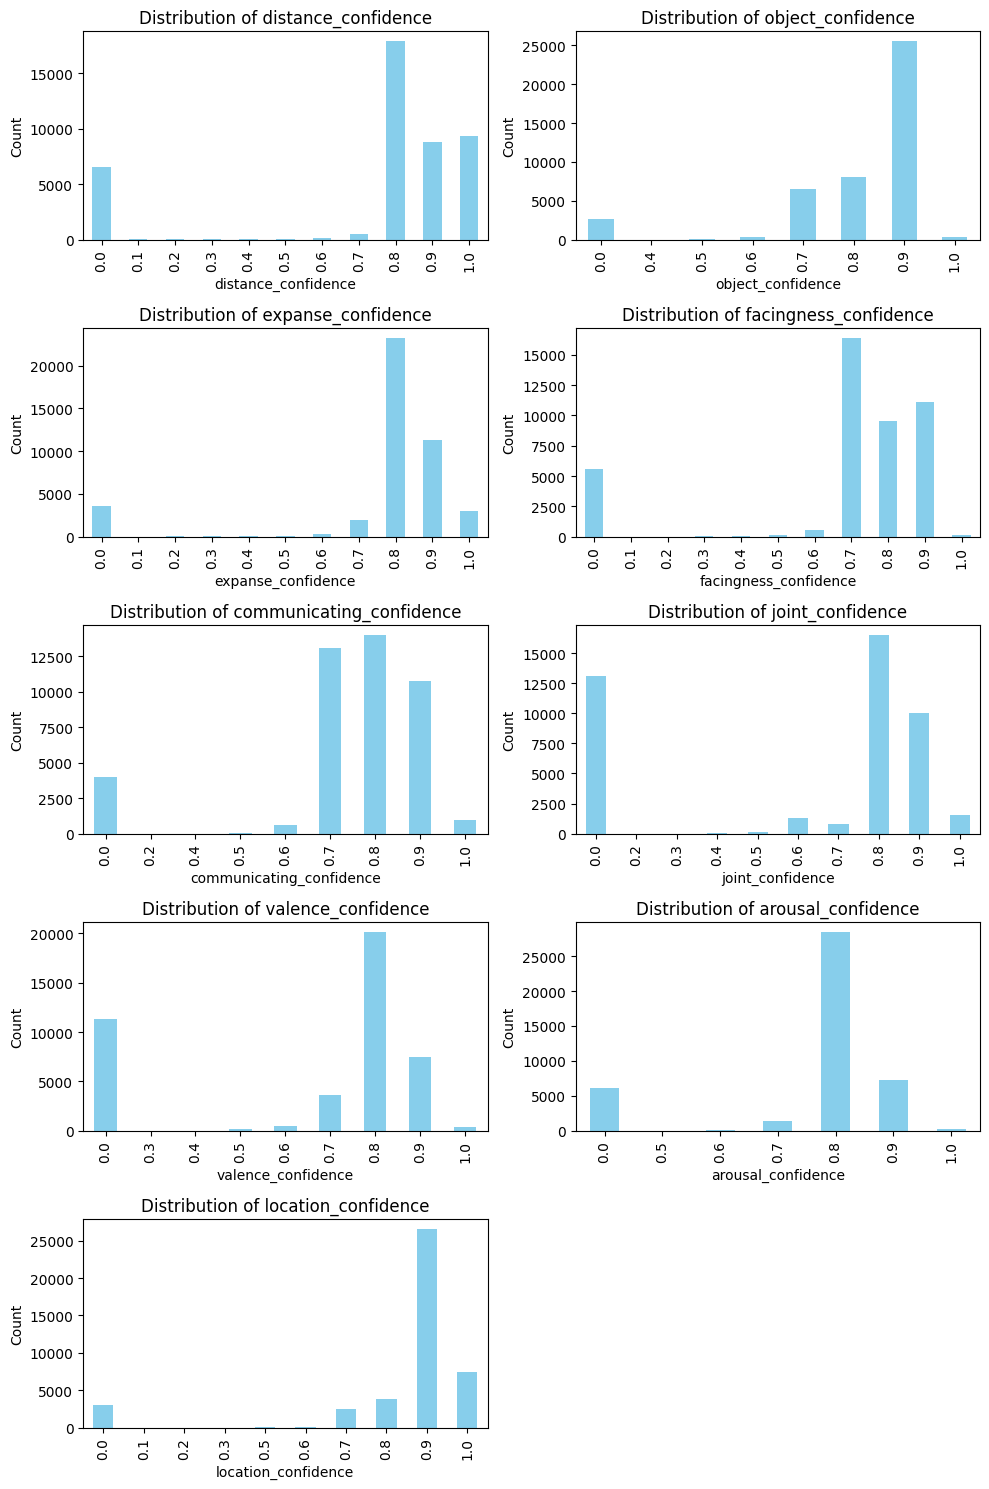

In [145]:
plot_categorical_with_nan(df, columns=confidence_columns)

Plot people count.

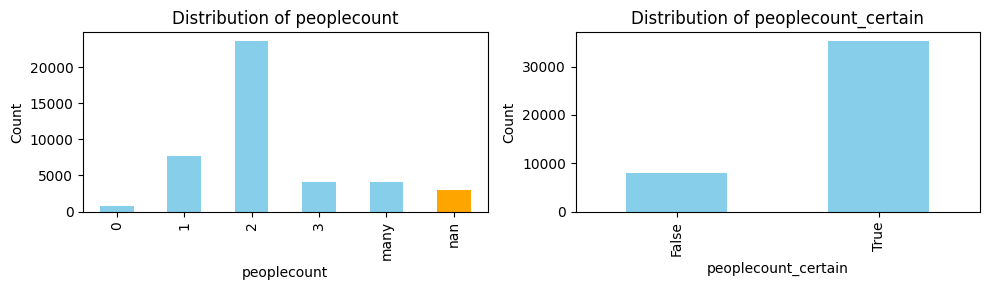

In [146]:
plot_categorical_with_nan(df, ['peoplecount','peoplecount_certain'])

Plot location.

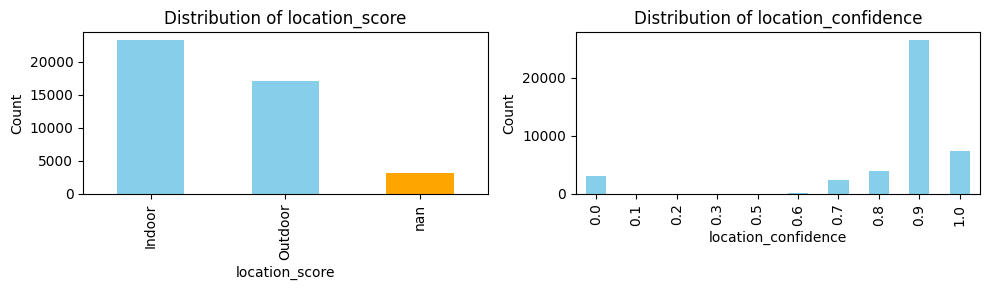

In [148]:
plot_categorical_with_nan(df, ['location_score', 'location_confidence'])